In [26]:
%%html
<style>
.container { width:80% !important; }
</style>

In [27]:
%load_ext autoreload
%autoreload 2
%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Horizontal edge detection

Objective of this notebook is to detect the y position of the shelf of such image

![alt text](http://i.stack.imgur.com/uBYiS.jpg "Logo Title Text 1")

The processing contains basically three steps:

* straight line detection
* scoring
* thresholding (post processing)

In [28]:
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.feature import canny
from skimage import data
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import roberts, sobel, scharr

## read the target image

In [29]:
image = imread("books.jpg", as_grey=True) * 255

## Straight line detection

use a [hough transform](http://scikit-image.org/docs/dev/auto_examples/plot_line_hough_transform.html) to detection straght line.

(-0.5, 298.5, 599.5, -0.5)

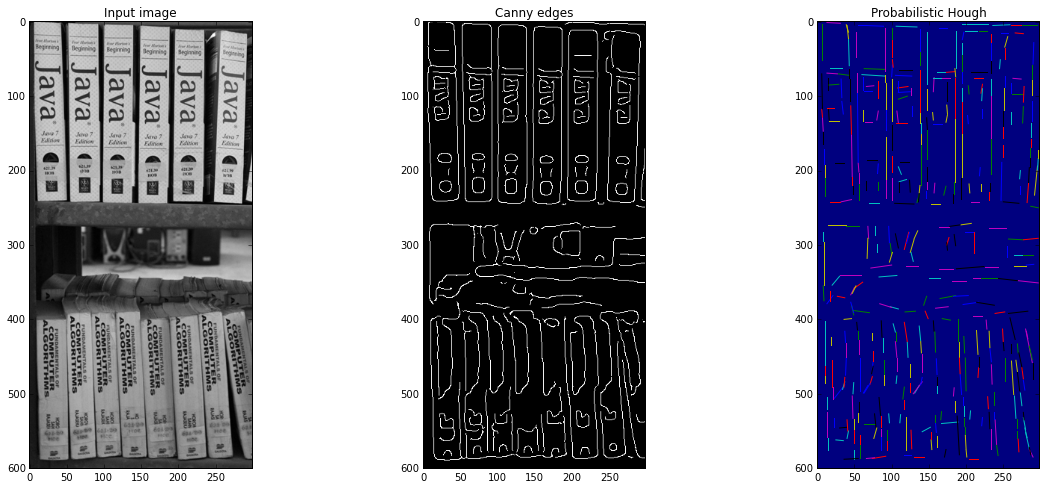

In [30]:
edges = canny(image, 4, 1, 25)
lines = probabilistic_hough_line(edges, threshold=2, line_length=10, line_gap=3)

fig2, ax = plt.subplots(1, 3, figsize=(20, 8))

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Input image')
ax[0].axis('image')

ax[1].imshow(edges, cmap=plt.cm.gray)
ax[1].set_title('Canny edges')
ax[1].axis('image')

ax[2].imshow(edges * 0)

for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))

ax[2].set_title('Probabilistic Hough')
ax[2].axis('image')

In [31]:
height, width = image.shape

## Scoring
for each y position, we define two scores:
* $s_h$: it describes how many long horizontal lines are located in the neighborhood. It is the sum over x projection of segments crossing the current y projection.
* $s_v$: it describes how many long vertical lines are located in the neighborhood. It is the sum over y projection of segments crossing the current y projection.

In [32]:
def proj_x(line):
    p0, p1 = line
    return np.abs(p0[0] - p1[0])

def proj_y(line):
    p0, p1 = line
    return np.abs(p0[1] - p1[1])

In [33]:
s_h = np.zeros(height)
s_v = np.zeros(height)
for line in lines:
    p0, p1 = line
    y1 = max(p0[1], p1[1])
    y0 = min(p0[1], p1[1])
    if proj_y(line) > 2:
        s_v[y0: y1] += proj_y(line)
    if proj_x(line) > 2:
        s_h[y0: y1] += proj_x(line)

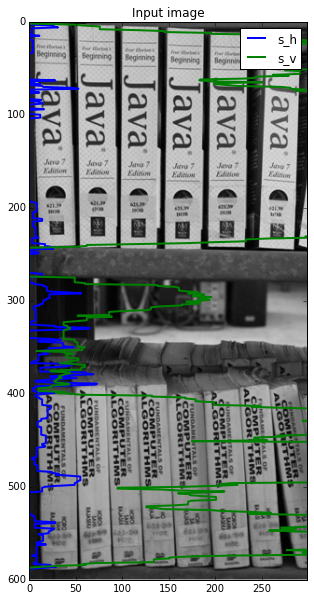

In [34]:
#fig2, ax = plt.subplots(1, 2, figsize=(8, 8))
plt.figure(figsize=(20, 10))
plt.imshow(image, cmap=plt.cm.gray)
plt.title('Input image')
plt.plot(s_h, np.arange(height), linewidth=2, label="s_h")
plt.plot(s_v, np.arange(height), linewidth=2, label="s_v")
plt.ylim([height, 0])
plt.xlim([0, width])
plt.legend()

The final scroe could be defined as:
$$ s_f = s_h / (s_v + 1)$$ 

In [35]:
import scipy.ndimage
s_f = 20 * s_h / (s_v + 1)
s_f = scipy.ndimage.filters.gaussian_filter1d(s_f, 1)

(0, 299)

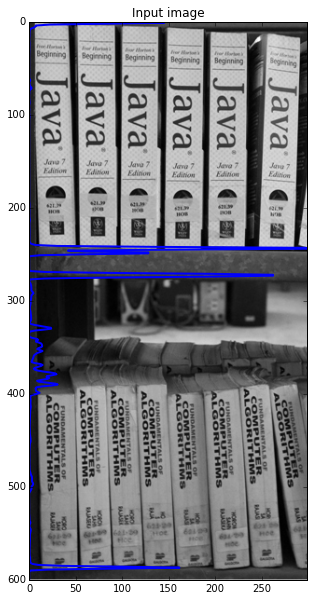

In [36]:

plt.figure(figsize=(20, 10))
plt.imshow(image, cmap=plt.cm.gray)
plt.title('Input image')
plt.plot(s_f, np.arange(height), linewidth=2, label="s_h")
plt.ylim([height, 0])
plt.xlim([0, width])

## post processing

In [37]:
import scipy.signal

In [38]:
cands = scipy.signal.find_peaks_cwt(s_f, np.arange(1, 50))
print zip(cands, s_f[cands])

[(2, 87.664760517956907), (71, 2.5452847868607602), (102, 0.39169761897105121), (149, 0.0), (245, 149.45870012221644), (273, 262.32569666520101), (383, 21.665549270125041), (450, 1.5577369452508747), (498, 3.9613964901181609), (548, 1.5148953881808653), (587, 161.59525615637753)]


/home/cardiologs/anaconda/lib/python2.7/site-packages/scipy/signal/_peak_finding.py:410: RuntimeWarning: divide by zero encountered in double_scalars
  snr = abs(cwt[line[0][0], line[1][0]] / noises[line[1][0]])


In [39]:
pairs = []
for c in cands:
    for d in cands:
        if (c < d) and (d -c < 100):
            pairs.append((c, d))

In [40]:
y_tagets = pairs[np.argmax([s_f[a] * s_f[b] for a, b in pairs])]

In [41]:
y0, y1 = y_tagets

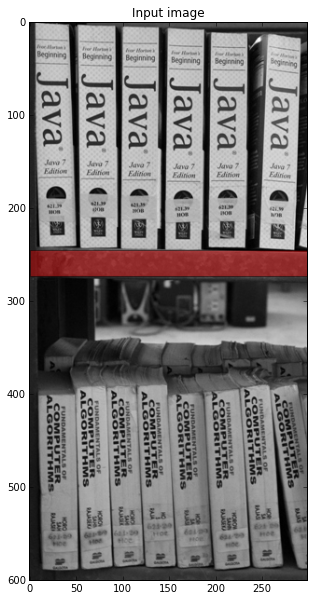

In [42]:
import matplotlib.patches as patches
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, aspect='equal')
ax.imshow(image, cmap=plt.cm.gray)
ax.set_title('Input image')
ax.add_patch(
    patches.Rectangle(
        (0, y0),
        width,
        y1 - y0,
        facecolor="red",
        alpha=0.4      # remove background
    )
)